In [1]:
from scipy.fftpack import fft, ifft
import numpy as np
import math
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as io

In [2]:
L = 30
n = 256
x2 = np.linspace(-L/2, L/2, n+1)
x = x2[0:n]
k_array = np.append(np.array(range(n//2 - 1)), np.array(range(-n//2, 0)))
k = (2*math.pi / L) * (k_array.transpose())
t = np.linspace(0, 2*math.pi, 101)
u = 2*(1/np.cosh(x))
ut = fft(u,axis=0)

In [3]:
def nls_rhs(t, ut):
    u = ifft(ut.transpose(), axis=0)
    L = 30
    n = 256
    k_array = np.append(np.array(range(n//2)), np.array(range(-n//2, 0)))
    k = (2*math.pi / L) * (k_array.transpose())
    rhs = -(1j/2) * (k**2) * ut + 1j * (fft(abs(u)**2 * u).transpose())
    return rhs

In [4]:
solver = scipy.integrate.solve_ivp(nls_rhs, t_span=[0, 2*math.pi], y0=ut, t_eval=t)

In [5]:
utsol = solver.y
utsol = utsol.transpose()

In [6]:
usol = ifft(utsol.transpose(), axis=0)
usol = usol.transpose()

<IPython.core.display.Javascript object>


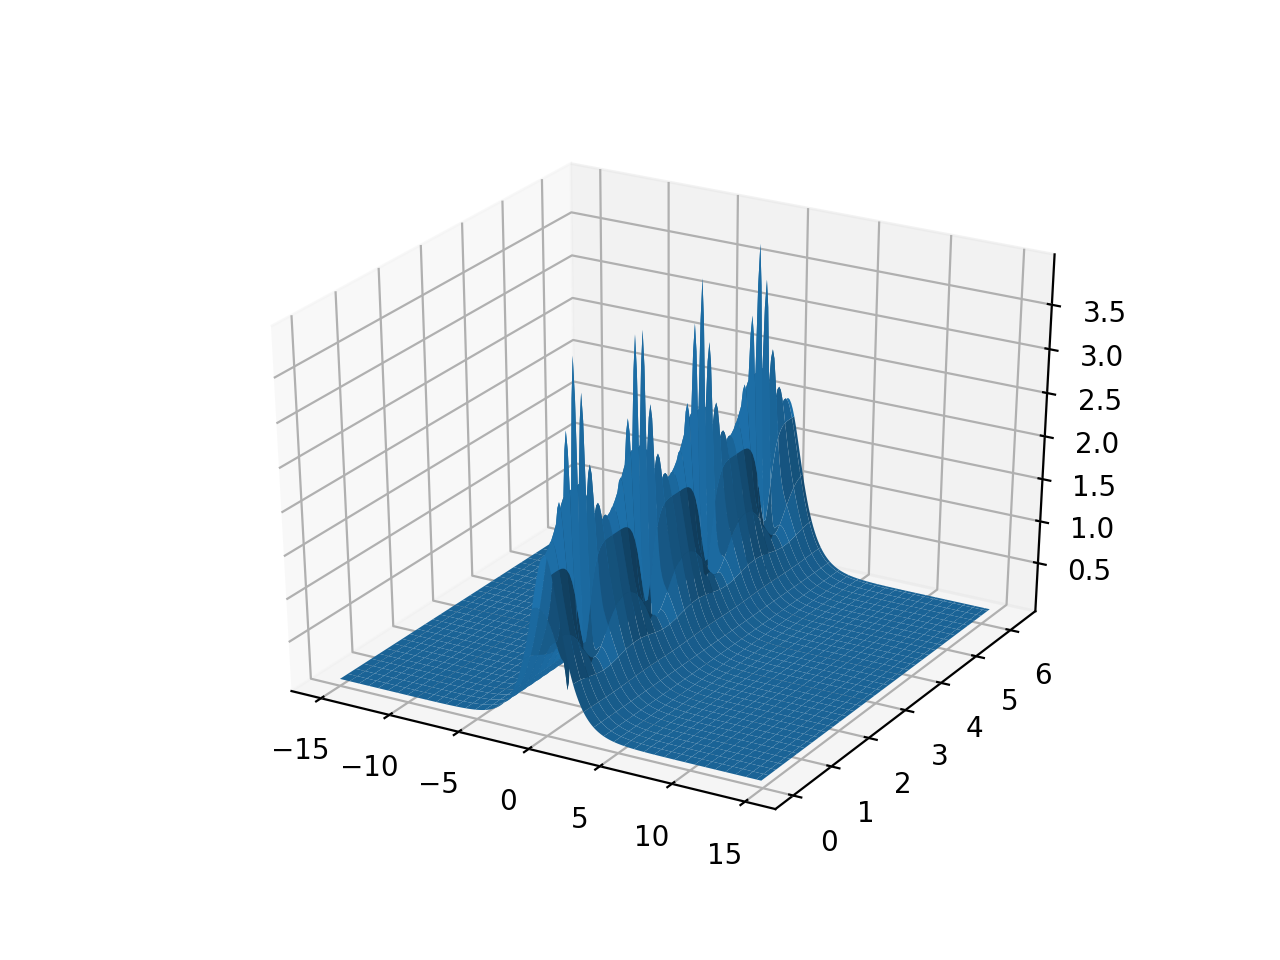

In [9]:
t = t.reshape(101,1)
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.plot_surface(X=x, Y=t, Z=abs(usol))
plt.show()

In [10]:
# error: (difference from the matlab result)
usol_real = io.loadmat('/Users/Lee/HPC/usol.mat')
print(np.max(abs(usol_real['usol'] - usol)))

0.0007405319860922554


Summary:

We have slightly different result from the matlab result:
Because of python's lack of direct 'sech' function, we use '1/cosh' instead
and fft in python includes all the imaginary parts (matlab ignores some of the insignificant ones).

the overall result difference is in e^-4 